# DAC Phase Calibration

Follow steps in notebook to produce dict in `pickles/calibrate_phase.pickle` for DAC channel synchronisation when performing IQ mixing.

Keys of dict are frequencies and values are lists. List index 0 is phase offset to apply to DAC_B (degrees) and index 1 is phase offset to apply to DAC_A (degrees).

In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

import pickle
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "172.24.106.21" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [4]:
# Calibration frequency range
freqs = np.arange(21, 3001, 1)

# Ensure frequency matching between DAC and ADC
freqs = soccfg.adcfreq(freqs, gen_ch=0, ro_ch=0)

In [5]:
# Calibration program class declaration
class CalibrationProgram(AveragerProgram):
    def __init__(self,soccfg, cfg):
        super().__init__(soccfg, cfg)

    def initialize(self):
        cfg=self.cfg   
        
        # Configure readout lengths and downconversion frequencies
        for ch in self.cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"]) # Initialise ADC

        # Create pulse with purely I component
        idata = 30000*np.ones(16*cfg["length"])
        for ch in self.cfg["gen_chs"]:
            self.declare_gen(ch=ch, nqz=1) # Initialise DAC
            self.add_pulse(ch=ch, name="measure", idata=idata) # Store pulse in memory
        
        # Configure DACs with I pulse 
        freq=soccfg.freq2reg(cfg["pulse_freq"])  # Convert to DAC frequency
        for ch in self.cfg["gen_chs"]:
            self.set_pulse_registers(ch=ch, style="arb", freq=freq, phase=cfg["res_phase"], gain=cfg["pulse_gain"], waveform="measure", mode="periodic") # Program DAC registers

        self.synci(200)  # Give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=self.cfg["ro_chs"],adc_trig_offset=self.cfg["adc_trig_offset"])  # Trigger ADC readout
        for ch in self.cfg["gen_chs"]:
            self.pulse(ch=ch, t=0) # Play DAC pulse

        self.wait_all() # Wait until the readout is over
        self.sync_all(200)  # Wait for measurement to complete

# Calibration program configuration
config={"gen_chs": [0, 1],
        "ro_chs": [0, 1],
        "reps":1000,
        "res_phase":soccfg.deg2reg(0),
        "length":10, # [Clock ticks]
        "readout_length":1000, # [Clock ticks]
        "pulse_gain":32000, # [DAC units]
        "adc_trig_offset": 1000, # [Clock ticks]
        "soft_avgs":1
       }

## Calibrate ADCs

First, we ensure that both ADCs give the same phase measurement when connected to the same DAC.

### ----- CONNECT DAC_A --> ADC_D -----

In [6]:
# Take ADC_D phase measurements
adc_d_phis = {}

for freq in freqs:
    # Acquire average I and Q components over readout window
    config['pulse_freq'] = freq
    prog = CalibrationProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)

    # Calculate phase from I and Q components
    adc_d_iq = avg_data[0][0][0] + 1j*avg_data[1][0][0]
    adc_d_phi = np.remainder(np.angle(adc_d_iq,deg=True)+360,360)
    adc_d_phis[freq] = adc_d_phi

soc.reset_gens()

In [ ]:
# # Plot ADC_D phase measurements (sanity check)
# adc_d_freqs, adc_d_phases = [], []
# for freq, phase in adc_d_phis.items():
#     adc_d_freqs.append(freq)
#     adc_d_phases.append(phase)

# plt.plot(adc_d_freqs, adc_d_phases)
# plt.xlabel("Frequency [MHz]")
# plt.ylabel("Phase [deg.]")
# plt.title("ADC_D Phase Offsets");

### ----- CONNECT DAC_A --> ADC_C -----

In [7]:
# Take ADC_C phase measurements
adc_c_phis = {}

for freq in freqs:
    # Acquire average I and Q components over readout window
    config['pulse_freq'] = freq
    prog = CalibrationProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)

    # Calculate phase from I and Q components
    adc_c_iq = avg_data[0][1][0] + 1j*avg_data[1][1][0]
    adc_c_phi = np.remainder(np.angle(adc_c_iq,deg=True)+360,360)
    adc_c_phis[freq] = adc_c_phi

soc.reset_gens()

In [ ]:
# # Plot ADC_C phase measurements (sanity check)
# adc_c_freqs, adc_c_phases = [], []
# for freq, phase in adc_c_phis.items():
#     adc_c_freqs.append(freq)
#     adc_c_phases.append(phase)

# plt.plot(adc_c_freqs, adc_c_phases)
# plt.xlabel("Frequency [MHz]")
# plt.ylabel("Phase [deg.]")
# plt.title("ADC_C Phase Offsets");

In [8]:
# Calculate phase offset between ADCs
adc_dac_phis = {}

for freq in adc_c_phis:
    adc_dac_phis[freq] = (adc_d_phis[freq] - adc_c_phis[freq]) % 360

## Sanity Check!

The phase offset between DACs is fairly conistent between sessions. The plot should therefore resemble that which exists below.

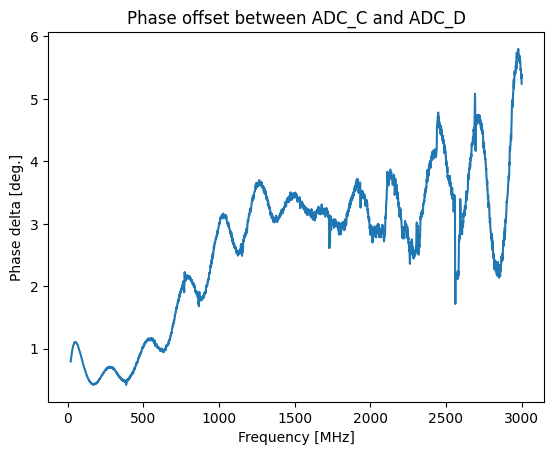

In [9]:
# Plot phase offsets between ADCs
adc_freqs, adc_phases = [], []
for adc_freq, adc_phase in adc_dac_phis.items():
    adc_freqs.append(adc_freq)
    adc_phases.append(adc_phase)

plt.plot(adc_freqs, adc_phases)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase delta [deg.]")
plt.title("Phase offset between ADC_C and ADC_D");

## Calibrate DACs

Now that both ADCs are giving the same readings, we can measure the phase of both DACs simultaneously and calculate the phase offset that will be compensated for.

### ----- CONNECT DAC_A --> ADC_C -----
### ----- CONNECT DAC_B --> ADC_D -----

In [10]:
# Take DAC phase measurements
dac_phis = {}

for freq in freqs:
    # Acquire average I and Q components over readout window
    config['pulse_freq'] = freq
    prog = CalibrationProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)

    # Calculate phase from I and Q components
    dac_a_iq = avg_data[0][1][0] + 1j*avg_data[1][1][0]
    dac_a_phi = np.remainder(np.angle(dac_a_iq,deg=True)+360,360)
    dac_b_iq = avg_data[0][0][0] + 1j*avg_data[1][0][0]
    dac_b_phi = np.remainder(np.angle(dac_b_iq,deg=True)+360,360)

    # Calculate DAC phase offsets
    dac_phis[freq] = (dac_b_phi - dac_a_phi - adc_dac_phis[freq]) % 360

soc.reset_gens()

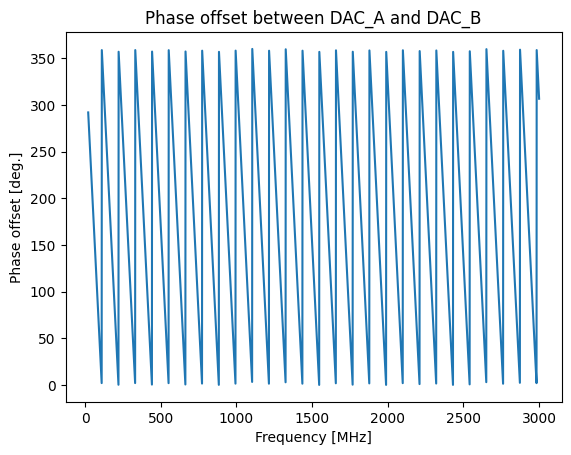

In [11]:
freqs, phases = [], []
for freq, phase in dac_phis.items():
    freqs.append(freq)
    phases.append(phase[0])

plt.plot(freqs, phases)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg.]")
plt.title("Phase offset between DAC_A and DAC_B");

In [12]:
# to save the data
with open('pickles/calibrate_phase.pickle', 'wb') as handle:
    pickle.dump(dac_phis, handle, protocol=pickle.HIGHEST_PROTOCOL)